In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from joblib import Parallel, delayed

from datasets import *

from sklearn.preprocessing import LabelEncoder

pd.set_option('display.max_columns', 150)

# AARRR Framework 지표 내용

## Acquisition

| 지표 | 정의 | 계산식 |
|------|------|------|
| **신규 사용자 수 (NU, New User)** | 특정 서비스에 방문한 이력이 없는 상태에서, 처음 방문하거나 상호작용한 사용자의 수 | - |
| **회원 가입 수 (Sign Up)** | 특정 서비스에 회원 가입한 사용자의 수 | - |
| **앱 다운로드 수 (App Installs)** | 특정 앱(어플리케이션)을 다운로드한 수 | - |
| **리드 수 (Leads)** | 일정 수준의 정보를 제공하는 잠재 고객, 혹은 고객 정보 그 자체의 수 | - |
| **고객 획득 비용 (CAC, Customer Acquisition Cost)** | 신규 고객 1명을 획득하기 위해 필요한 비용 | **블렌디드 CAC** : 고객 획득을 위해 투입한 전체 금액 / 획득한 전체 고객 수 <br> **매체별 CAC** : 특정 광고 매체에서 고객 획득을 위해 투입한 금액 / 해당 매체에서 획득한 고객 수 |
| **(광고) 클릭률 (CTR, Click-Through Rate)** | 광고에 노출된 사용자 중에, 광고를 클릭한 사용자의 비율 | (광고 클릭 수 / 광고 노출 수) * 100 |
| **(광고) 조회율 (VTR, View-Through Rate)** | 영상 광고에 노출된 사용자 중에, 영상을 조회한 사용자의 비율 | (광고 조회 수 / 광고 노출 수) * 100 |
| **(광고) 전환율 (CVR, Conversion Rate)** | 광고를 클릭하여 유입된 사용자 중에, 주요한 전환 행동을 한 사용자의 비율 | (전환 수 / 광고 클릭 수) * 100 |
| **CPM (Cost-Per-Mille)** | 광고 1,000번 노출당 비용 | (총 광고 비용 / 광고 노출 수) * 1000 |
| **CPC (Cost-Per-Click)** | 광고 클릭당 비용 | 총 광고 비용 / 광고 클릭 수 |
| **CPV (Cost-Per-View)** | 영상 광고 조회당 비용 | 총 광고 비용 / 광고 조회 수 |
| **CPA (Cost-Per-Action)** | 특정 액션(회원가입, 상품 구매, 이벤트 참여 등)당 비용 | 총 광고 비용 / 특정 액션이 발생한 수 |
| **CPI (Cost-Per-Install)** | 앱 설치당 비용 | 총 광고 비용 / 앱 설치 수 |

## Activation

| 지표 | 정의 | 계산식 |
|------|------|------|
| **체류 시간 (DT, Duration Time)** | 사용자가 특정 서비스에 머무른 시간 | **평균 체류 시간** = 총 체류 시간(사용자들이 방문하여 머무른 전체 시간) / 방문한 전체 사용자 수 |
| **평균 페이지 체류 시간 (Average Time on Page)** | 사용자가 서비스 내의 단일 페이지에서 머무른 평균 시간 | 단일 페이지의 총 체류 시간 / 해당 페이지를 방문한 사용자 수 |
| **평균 세션 시간 (Average Session Duration)** | 단일 세션 동안 사용자가 특정 서비스에서 머무른 평균 시간 | 총 세션 시간(각 세션의 ‘세션 종료 시각 - 세션 시작 시각’의 총합) / 세션 수 |
| **페이지 뷰 (PV, Page View)** | 특정 웹사이트나 서비스를 방문하여 열람한 페이지의 수 (중복 포함) | - |
| **순 방문자 수 (UV, Unique Visitor)** | 특정 웹사이트나 서비스에 방문한 사용자 중 중복되는 사용자를 배제한 순 방문자 수 | - |
| **페이지 이탈률 (Bounce Rate, 반송률)** | 웹이나 앱에서 첫 페이지만 조회한 후, 추가적인 행동이나 상호작용 없이 바로 이탈한 사용자의 비율 | (반송 수 / 방문 수) * 100 <br> *반송 수 : 랜딩 페이지에 방문하여 1PV만을 발생시킨 방문의 수* |
| **Aha-moment 전환율** | Aha-moment를 경험하는 사용자의 비율 | (Aha-moment를 경험한 사용자 수 / 전체 사용자 수) * 100 |
| **구매 전환율 / 구독 전환율** | 전체 방문자 중 구매/구독을 한 사용자의 비율 | (구매 수 or 구독 수 / 방문 수) * 100 |
| **세부 퍼널 단계별 전환율** | 세부 퍼널(Aha-moment 퍼널, 구매 퍼널, 구독 퍼널 등) 안에서의 단계별 전환율 | (이후 단계로 전환된 수 / 이전 단계의 수) * 100 |

## Retention

| 지표 | 정의 | 계산식 |
|------|------|------|
| **유지율 (Retention Rate, 잔존율)** | 사용자가 유지되는 비율 | (유지된 사용자 수 / 기존 사용자 수) * 100 |
| **이탈률 (Churn Rate)** | 사용자가 이탈하는 비율 | (이탈한 사용자 수 / 기존 사용자 수) * 100 |
| **재구매율 / 재구독률** | 첫 구매후 특정 단위 기간(1주, 1개월, 3개월 등)내에 다시 구매/구독하는 사용자의 비율 | (재구매 or 재구독한 사용자 수 / 기존 사용자 수) * 100 |
| **사용자 고착도 (Stickiness)** | 사용자가 서비스에 계속해서 방문하는 정도 | DAU(일간 활성 사용자 수) / MAU(월간 활성 사용자 수) * 100 |
| **활성 사용자 수 (AU, Active User)** | 특정 웹사이트, 앱 또는 플랫폼과 상호작용하며 활성화된 사용자 수 (중복 제거) | - |
| **기간별 활성 사용자 수** | 특정 기간 동안 활성 사용자 수 (HAU, DAU, WAU, MAU) | **HAU** : 시간당 활성 사용자 수 <br> **DAU** : 일간 활성 사용자 수 <br> **WAU** : 주간 활성 사용자 수 <br> **MAU** : 월간 활성 사용자 수 |

## Revenue

| 지표 | 정의 | 계산식 |
|------|------|------|
| **매출 (Revenue)** | 비즈니스가 고객에게 상품 혹은 서비스를 판매하여 창출하는 총 금액으로, 비즈니스 운영과 관련된 비용을 공제하기 전의 금액 | - |
| **매출총이익 (Gross Profit, 마진)** | 매출액에서 매출원가(COGS, 제품이나 서비스를 제공하는 데 드는 직접 비용)를 차감한 금액 | 매출 - 매출 원가 |
| **매출총이익률 (Gross Profit Margin, 마진율)** | 매출 대비 매출총이익(마진)의 비율 | {(매출 - 매출 원가) / 매출} * 100 |
| **순이익 (Net Profit, Net Income)** | 매출에서 매출 원가, 인건비, 광고비, 세금 등 비즈니스가 사용한 모든 비용을 차감하고 영업외수익과 비용까지 고려한 뒤 남은 금액으로, 비즈니스의 순수한 이익 | 매출 - 매출 원가 - 판매관리비 + (금융수익 - 금융비용) + (영업외수익 - 영업외비용) - 법인세비용 |
| **MRR (Monthly Recurring Revenue, 월간 반복 매출)** | 매월 반복적으로 발생하는 매출 | 기존 고객의 월간 매출(전월 매출) - 이탈 고객의 월간 기여 매출 + 신규/부활 고객의 월간 매출 + 플랜 업그레이드/다운그레이드로 인한 월간 매출 차액 |
| **ARR (Annual Recurring Revenue, 연간 반복 매출)** | 매년 반복적으로 발생하는 매출 | 기존 고객의 연간 매출(전년도 매출) - 이탈 고객의 연간 기여 매출 + 신규/부활 고객의 연간 매출 + 플랜 업그레이드/다운그레이드에 따른 연간 매출 차액 |
| **ROI (Return on Investment, 투자 수익률)** | 투자 비용(광고비를 포함한 모든 비용) 대비 수익률(순이익 기준) | (순이익 / 전체 투자 비용) * 100 |
| **ROAS (Return on Ad Spend, 광고 수익률)** | 투입한 광고 비용 대비 수익률(매출 기준) | (광고 캠페인을 통해 발생한 매출 / 투입한 총 광고 비용) * 100 <br> **매체별 ROAS** : (특정 광고 매체에서 발생한 매출 / 해당 매체에 투입한 총 광고 비용) * 100 |
| **PU (Paying User, 유료 결제 사용자 수)** | 유료 결제를 한 사용자의 수 | - |
| **ARPU (Average Revenue Per User)** | 고객 평균 매출로, 무료 사용자와 유료 결제 사용자를 포함한 전체 사용자 1인당 평균 매출 | 총 매출 / 전체 사용자 수 |
| **ARPPU (Average Revenue per Paying User)** | 유료 고객 평균 매출로, 유료 결제 사용자 1인당 평균 매출 | 총 매출 / 유료 결제 사용자 수 (PU) |
| **ARPDAU (Average Revenue Per Daily Active User)** | DAU(일간 활성 사용자) 1인당 일 평균 매출 | 일 매출 / DAU(일간 활성 사용자 수) |
| **LTR (Lifetime Revenue, 고객 생애 매출)** | 고객 한 명이 제품/서비스를 이용하는 전체 생애 동안 우리 비즈니스에서 발생시킬 것으로 예상되는 기대 매출 | 고객이 생애 동안 누적하여 발생시킨 총 매출의 합 / 고객 수 |
| **LTV (Lifetime Value, 고객 생애 가치)** | 고객 한 명이 제품/서비스를 이용하는 전체 생애 동안 우리 비즈니스에서 발생시킬 것으로 예상되는 기대 가치(순이익 기준) | {평균 구매 금액 * 마진율 * 구매 빈도(구매 횟수) * 고객 수명} - (고객 획득 비용 + 고객 유지 비용) |

## Referral

| 지표 | 정의 | 계산식 |
|------|------|------|
| **바이럴 주기 시간 (Viral Cycle Time)** | 기존 사용자가 친구를 초대하고, 초대받은 친구가 신규 사용자로 유입되기까지 걸리는 시간 | - |
| **바이럴 계수 (Viral Coefficient)** | 기존 사용자 1명당 만들어내는 신규 사용자의 수 | 기존 사용자 1명당 평균 친구 초대 수 * 초대받은 친구의 초대 수락 비율 |
| **NPS (Net Promoter Score, 순 추천 지수)** | 기존 사용자가 제품이나 서비스, 브랜드를 추천할 가능성으로, 고객 충성도를 측정하는 표준 척도 | 추천 그룹의 비율(%) - 비추천 그룹의 비율(%) |
| **SNS 공유 수 (SNS Share Rate)** | 공유 수, 댓글 수, 태그 수 등 | - |

---
# 사용자 여정 로드맵 기준 분석

## ARPPU & ARPU

데이터 기한 내용
- complete.subscription : 2022-01-01 ~ 2024-01-01
- renew.subscription : 2022-09-08 ~ 2024-01-01
- resubscribe.subscription : 2022-09-08 ~ 2024-01-01

ARPPU 와 ARPU를 구하기 전 유의사항
- 기간이 다른 데이터가 포함될 경우 ARPPU/ARPU가 왜곡될 가능성이 존재한다. <br/>
    → 해결방법 : 세 데이터가 모두 존재하는 데이터 기간, complete.subscription만 존재하는 데이터 기간을 따로 분리하여 표기하였다.
- merge(병합) 과정에서 NaN 값이 생길 가능성이 생긴다. <br/>
    → 해결방법 : 모든 결제 데이터를 merge를 사용하지 않고 axis=0 방향으로 concat을 시켰다. (데이터 컬럼값이 모두 동일하기 때문)
- ARPPU 계산 공식을 적용할 때 데이터 정렬 문제. <br/>
    → 해결방법 : period를 기준으로 groupby하면 period가 순차적으로 정렬된다.

데이터 공통 기한
- 2022-09-08 ~ 2024-01-01

분리된 데이터 (complete.subscription)
- 2022-01-01 ~ 2022-09-08

### 공통 데이터란

In [95]:
# 데이터 불러오기
complete_subscription_df = complete.subscription()
renew_subscription_df = renew.subscription()
resubscribe_df = resubscribe.subscription()

In [96]:
# 함수 정의

# period 변환 함수
def change_period(data):
    data = data.copy()
    data['period'] = data['client_event_time'].dt.to_period('M')
    
    return data

# groupby 함수
def groupby(data):
    # 유료 사용자를 기준으로 집계
    data = data.groupby('period').agg(
        total_paid_amount = ('paid_amount', 'sum'),  # 총 유료 금액
        total_count = ('user_id', 'count'),  # 전체 결제 건 수
        total_user = ('user_id', 'nunique'), # 전체 유저 수
        one_month_plan_user = ('plan.price', lambda x: (x.isin([15920])).sum()),  # 1개월 플랜 사용자
        three_month_plan_user = ('plan.price', lambda x: (x.isin([42960])).sum()),  # 3개월 플랜 사용자
        one_year_plan_user = ('plan.price', lambda x: (x.isin([131600])).sum()),  # 1년 플랜 사용자
        promotion_plan_user = ('plan.price', lambda x: (x.isin([79200, 95520, 95200, 91200, 87200, 83200])).sum()),  # 프로모션 플랜 사용자
    )
    return data


In [97]:
# 모든 결제 완료 이력
concat_df = pd.concat([complete_subscription_df, renew_subscription_df, resubscribe_df], axis=0)

# 필요한 데이터 컬럼만 추출
concat_df = concat_df[['user_id', 'client_event_time', 'event_type', 'plan.price', 'paid_amount']]

# Data Type 변경
concat_df['client_event_time'] = pd.to_datetime(concat_df['client_event_time']) + pd.Timedelta(hours=9)
concat_df['client_event_time'] = concat_df['client_event_time'].dt.date

# 특정한 열에 중복값이 있는지 체크 후 첫번째 값만 남기고 제거
concat_df = concat_df.drop_duplicates(subset=['user_id', 'client_event_time', 'paid_amount'], keep='first')

# 날짜 비교를 위한 데이터 재변환
concat_df['client_event_time'] = pd.to_datetime(concat_df['client_event_time'])

# 데이터 확인
display(concat_df)

,user_id,client_event_time,event_type,plan.price,paid_amount
0,1116a2ae90ca6b06f85feba27ad51ef0,2023-04-06,complete.subscription,15920,15920
1,c0f5678df8967163e6e2c464ed006791,2023-04-10,complete.subscription,131600,131600
2,79421b5d038205ad7adbb1e2c3b89741,2023-03-12,complete.subscription,131600,119756
3,bdffe1f18684704d4ea2d7eebcaed180,2023-04-12,complete.subscription,131600,131600
4,d4f54ecf6c4d7bf8742f80505f02d6dc,2023-05-31,complete.subscription,15920,15920
...,...,...,...,...,...
786,482cf2ed1eefbe648ce156e43d323114,2023-10-21,resubscribe.subscription,15920,15920
787,b6b9428216580dbdc053e0bb19083be1,2023-07-31,resubscribe.subscription,15920,15920
788,eaff98093acb9a109975957cafb2d105,2023-12-31,resubscribe.subscription,95520,95520
789,e6aace24ed8703d42ce43c4b8b1c7d66,2023-12-29,resubscribe.subscription,95520,95520


In [98]:
concat_df['plan.price'].unique()

array([ 15920, 131600,  95200,  91200,  87200,  83200,  19920,  14328,
        42960, 118440,  79200,  95520])

In [99]:
# complete.subscription, renew.subscription, resubscibe.subscription의 데이터가 모두 존재하는 부분을 분리
separated_df1 = concat_df[(concat_df['client_event_time'] >= '2022-09-08') & (concat_df['client_event_time'] <= '2024-01-01')]

# complete.subscription만 존재하는 데이터 분리
separated_df2 = concat_df[concat_df['client_event_time'] < '2022-09-08']

In [100]:
# 분리된 데이터 리스트 저장
list_df = [separated_df1, separated_df2]

# 임시용 보관 데이터 생성
list_groupby = []

for i in range(len(list_df)):
    # Month period 타입 변환
    month_df = change_period(list_df[i])

    # groupby 및 reset_index()
    df_groupby = groupby(month_df).reset_index()

    # 데이터 타입 변환
    df_groupby['period'] = df_groupby['period'].dt.to_timestamp()

    # 리스트에 저장
    list_groupby.append(df_groupby)
    
# 결과 저장
separated_df1_month, separated_df2_month = list_groupby

# 데이터 확인
for list in list_groupby:
    display(list)

,period,total_paid_amount,total_count,total_user,one_month_plan_user,three_month_plan_user,one_year_plan_user,promotion_plan_user
0,2022-09-01,24248427,922,918,715,154,53,0
1,2022-10-01,30143986,1106,1097,801,246,59,0
2,2022-11-01,27486958,1727,1721,1513,155,59,0
3,2022-12-01,185734071,2964,2906,714,87,0,2163
4,2023-01-01,199342010,2709,2677,487,96,0,2126
5,2023-02-01,59286291,979,967,543,72,364,0
6,2023-03-01,33452804,759,738,532,50,176,0
7,2023-04-01,38089315,1089,1081,871,46,172,0
8,2023-05-01,33894113,1109,1105,933,35,133,0
9,2023-06-01,41067210,1480,1470,1296,29,149,0


,period,total_paid_amount,total_count,total_user,one_month_plan_user,three_month_plan_user,one_year_plan_user,promotion_plan_user
0,2022-01-01,2466721,54,54,20,26,8,0
1,2022-02-01,21949193,535,531,311,133,91,0
2,2022-03-01,25090147,652,633,402,139,111,0
3,2022-04-01,23275321,562,544,320,134,108,0
4,2022-05-01,23804028,632,617,361,173,98,0
5,2022-06-01,23111595,602,583,342,166,94,0
6,2022-07-01,26527391,710,691,430,168,112,0
7,2022-08-01,16304670,399,383,236,83,80,0
8,2022-09-01,1697591,50,50,33,12,5,0


---
### ARPPU

In [101]:
# 데이터 초기화
arppu_list = []

# ARPPU 계산
for list in list_groupby:
    list['ARPPU'] = round(list['total_paid_amount'] / list['total_user'], 2)
    arppu_list.append(list)

# 데이터 확인
for list in arppu_list:
    display(list)

,period,total_paid_amount,total_count,total_user,one_month_plan_user,three_month_plan_user,one_year_plan_user,promotion_plan_user,ARPPU
0,2022-09-01,24248427,922,918,715,154,53,0,26414.41
1,2022-10-01,30143986,1106,1097,801,246,59,0,27478.57
2,2022-11-01,27486958,1727,1721,1513,155,59,0,15971.50
3,2022-12-01,185734071,2964,2906,714,87,0,2163,63914.00
4,2023-01-01,199342010,2709,2677,487,96,0,2126,74464.70
5,2023-02-01,59286291,979,967,543,72,364,0,61309.50
6,2023-03-01,33452804,759,738,532,50,176,0,45329.00
7,2023-04-01,38089315,1089,1081,871,46,172,0,35235.26
8,2023-05-01,33894113,1109,1105,933,35,133,0,30673.41
9,2023-06-01,41067210,1480,1470,1296,29,149,0,27936.88


,period,total_paid_amount,total_count,total_user,one_month_plan_user,three_month_plan_user,one_year_plan_user,promotion_plan_user,ARPPU
0,2022-01-01,2466721,54,54,20,26,8,0,45680.02
1,2022-02-01,21949193,535,531,311,133,91,0,41335.58
2,2022-03-01,25090147,652,633,402,139,111,0,39636.88
3,2022-04-01,23275321,562,544,320,134,108,0,42785.52
4,2022-05-01,23804028,632,617,361,173,98,0,38580.27
5,2022-06-01,23111595,602,583,342,166,94,0,39642.53
6,2022-07-01,26527391,710,691,430,168,112,0,38389.86
7,2022-08-01,16304670,399,383,236,83,80,0,42570.94
8,2022-09-01,1697591,50,50,33,12,5,0,33951.82


In [102]:
# ARPPU 그래프 생성 전 전처리 작업란
# period x열 생성을 위한 병합
merged_df = pd.merge(
    arppu_list[0],
    arppu_list[1],
    on='period', how='outer',
    suffixes=('_df1', '_df2'))

# period를 string으로 변환
merged_df['period'] = merged_df['period'].dt.strftime('%Y-%m')

# '2024-01' 데이터 제거
merged_df = merged_df[merged_df['period'] != '2024-01']

# 데이터 확인
display(merged_df)

,period,total_paid_amount_df1,total_count_df1,total_user_df1,one_month_plan_user_df1,three_month_plan_user_df1,one_year_plan_user_df1,promotion_plan_user_df1,ARPPU_df1,total_paid_amount_df2,total_count_df2,total_user_df2,one_month_plan_user_df2,three_month_plan_user_df2,one_year_plan_user_df2,promotion_plan_user_df2,ARPPU_df2
0,2022-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2466721.0,54.0,54.0,20.0,26.0,8.0,0.0,45680.02
1,2022-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21949193.0,535.0,531.0,311.0,133.0,91.0,0.0,41335.58
2,2022-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25090147.0,652.0,633.0,402.0,139.0,111.0,0.0,39636.88
3,2022-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23275321.0,562.0,544.0,320.0,134.0,108.0,0.0,42785.52
4,2022-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23804028.0,632.0,617.0,361.0,173.0,98.0,0.0,38580.27
5,2022-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23111595.0,602.0,583.0,342.0,166.0,94.0,0.0,39642.53
6,2022-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26527391.0,710.0,691.0,430.0,168.0,112.0,0.0,38389.86
7,2022-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16304670.0,399.0,383.0,236.0,83.0,80.0,0.0,42570.94
8,2022-09,24248427.0,922.0,918.0,715.0,154.0,53.0,0.0,26414.41,1697591.0,50.0,50.0,33.0,12.0,5.0,0.0,33951.82
9,2022-10,30143986.0,1106.0,1097.0,801.0,246.0,59.0,0.0,27478.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [103]:
# Subscribe Plan Count 그래프 생성 전 전처리 작업란
# melt()를 이용하여 데이터 변환 후 중복된 period 값 합산
temp_list = []
for i in range(2):
    name1 = f'one_month_plan_user_df{i+1}'
    name2 = f'three_month_plan_user_df{i+1}'
    name3 = f'one_year_plan_user_df{i+1}'
    name4 = f'promotion_plan_user_df{i+1}'

    data = merged_df.melt(
        id_vars='period',
        value_vars=[name1, name2, name3, name4],
        var_name='plan_type',
        value_name='user_count')

    # 'df1'과 'df2'를 제거한 새로운 plan_type을 생성
    data['plan_type'] = data['plan_type'].str.replace('_df1', '').str.replace('_df2', '')

    # '2024-01' 데이터 제거
    data = data[data['period'] != '2024-01']

    temp_list.append(data)

# 두 데이터프레임을 합치고 동일한 period와 plan_type 값을 그룹화하여 합산
subscribe_plan_df = pd.concat(temp_list).groupby(['period', 'plan_type']).sum().reset_index()

# 데이터 확인
display(subscribe_plan_df)

,period,plan_type,user_count
0,2022-01,one_month_plan_user,20.0
1,2022-01,one_year_plan_user,8.0
2,2022-01,promotion_plan_user,0.0
3,2022-01,three_month_plan_user,26.0
4,2022-02,one_month_plan_user,311.0
...,...,...,...
91,2023-11,three_month_plan_user,15.0
92,2023-12,one_month_plan_user,1066.0
93,2023-12,one_year_plan_user,122.0
94,2023-12,promotion_plan_user,1478.0


C:\Users\lento\AppData\Local\Temp\ipykernel_17356\3627446777.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)


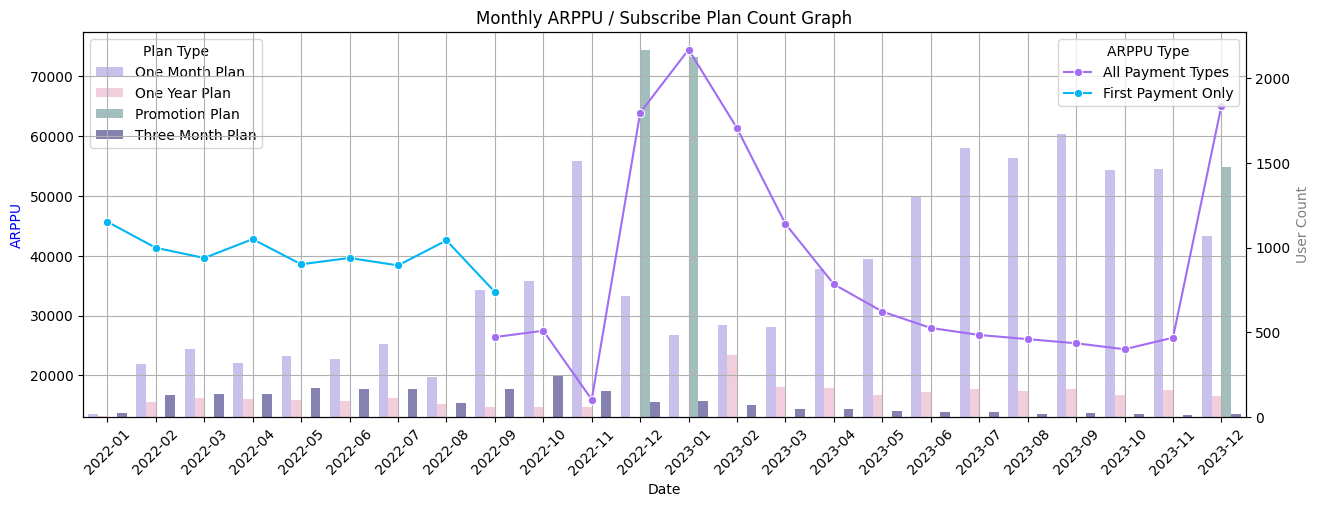

In [104]:
# 그래프 생성
fig, ax1 = plt.subplots(figsize=(15, 5))

# 라인 플롯
sns.lineplot(x=merged_df['period'], y=merged_df['ARPPU_df1'], marker='o', ax=ax1, label='All Payment Types', color='#a26cf3')
sns.lineplot(x=merged_df['period'], y=merged_df['ARPPU_df2'], marker='o', ax=ax1, label='First Payment Only', color='#01b6f3')

# 바 플롯을 보조로 사용하기 위한 준비
ax2 = ax1.twinx()

# 색상 설정
plan_colors = {
    'one_month_plan_user': '#c5b9f2', 
    'three_month_plan_user': '#7e79b8', 
    'one_year_plan_user': '#f8c8dc', 
    'promotion_plan_user': '#9dc3c1'
}

# 바 플롯 그리기 (색상 지정 및 alpha 조정)
sns.barplot(x='period', y='user_count', hue='plan_type', data=subscribe_plan_df, ax=ax2, palette=plan_colors)

# zorder 조정
ax1.set_zorder(3)
ax2.set_zorder(2)
ax1.grid(True, zorder=0)

# 라벨 및 제목 설정
ax1.set_xlabel('Date')
ax1.set_ylabel('ARPPU', color='b')
ax2.set_ylabel('User Count', color='gray')
plt.title('Monthly ARPPU / Subscribe Plan Count Graph')

# x축 회전
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

# 투명하게 만들어서 grid가 보이도록 설정
ax1.patch.set_visible(False)

# 범례 수동으로 설정 (색상과 항목이 매칭되도록)
handles, labels = ax2.get_legend_handles_labels()
legend2 = ax1.legend( title='ARPPU Type', loc='upper right')
legend2 = ax2.legend(handles=handles, labels=['One Month Plan', 'One Year Plan', 'Promotion Plan', 'Three Month Plan'], title='Plan Type', loc='upper left')

# 범례 최상단 배치
legend2.set_zorder(4)

plt.show()

---
### ARPU 계산 전 데이터 전처리

start.free_trial, enter.lesson_page 데이터를 통한 무료체험 유저 데이터 필터링

In [105]:
# 데이터 불러오기
# 기존 데이터는 주석 처리
start_free_trial_df = start.free_trial()
complete_signup_df = complete.signup()
enter_lesson_page_df = enter.lesson_page()
# complete_subscription_df = complete.subscription()

e:\Visual Studio Code\codeit\intermediate_project\datasets.py:132: DtypeWarning: Columns (9,13,15) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(file_path)


In [106]:
# 임시 저장할 리스트 생성
temp_list = []

for data in [complete_signup_df, enter_lesson_page_df, complete_subscription_df]:
    
    # 필요한 컬럼 가져오기
    if 'is_trial' in data.columns:
        data = data[['user_id', 'client_event_time', 'event_type', 'is_trial']]
    else:
        data = data[['user_id', 'client_event_time', 'event_type']]

    # 데이터 타입 변환
    data['client_event_time'] = pd.to_datetime(data['client_event_time'])

    # 한국 시간으로 변환
    data['client_event_time'] = data['client_event_time'] + pd.Timedelta(hours=9)

    # # start.free_trial의 마지막 데이터를 기준으로 시간 필터링
    # data = data[data['client_event_time'] > '2023-05-01']

    # enter.lesson_page 데이터에서 조건에 맞는 데이터 필터링
    if data['event_type'].isin(['enter.lesson_page']).any():

        # is_trial이 notnull이고, 그 값이 True인 값 필터링
        data = data[(data['is_trial'].notnull()) & (data['is_trial'] == True)]

        # is_trial 컬럼 삭제
        data = data.drop(labels='is_trial', axis=1)

        # 작업이 완료된 데이터 중 user_id가 겹치는 내용이 있을 경우 first값을 반환
        data = data.drop_duplicates(subset='user_id', keep='first')

    # complete.subscription 중 user_id가  겹치는 내용이 있을 경우 first값을 반환
    if data['event_type'].isin(['complete.subscription']).any():
        data = data.drop_duplicates(subset='user_id', keep='first')

    # period 컬럼 및 데이터 추가
    data['period'] = data['client_event_time'].dt.to_period('M')

    # 임시 리스트에 데이터 append
    temp_list.append(data)

# 데이터 concat
for_arpu_concat_df = pd.concat(temp_list, axis=0)

# concat한 데이터를 user_id, client_event_time, period를 기준으로 groupby후 event_type 표기
# groupby시 공통으로 묶인 데이터가 오름차순으로 정렬됨
# 차후 작업의 유용성을 위해 reset_index()를 통한 인덱스 초기화
for_arpu_groupby = for_arpu_concat_df.groupby(['user_id', 'client_event_time', 'period'])[['event_type']].sum().reset_index()

# 데이터 확인
display(for_arpu_concat_df)

C:\Users\lento\AppData\Local\Temp\ipykernel_17356\3099469032.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['client_event_time'] = pd.to_datetime(data['client_event_time'])
C:\Users\lento\AppData\Local\Temp\ipykernel_17356\3099469032.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['client_event_time'] = data['client_event_time'] + pd.Timedelta(hours=9)
C:\Users\lento\AppData\Local\Temp\ipykernel_17356\3099469032.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

,user_id,client_event_time,event_type,period
0,74d17c27a41656e7788b0c81d9f76cda,2023-04-06 06:33:26.068,complete.signup,2023-04
1,06b6868000a5d576180aca47896d6cce,2023-04-06 06:45:18.672,complete.signup,2023-04
2,e131c319972bd580146c5a2faba26613,2023-04-10 23:47:56.424,complete.signup,2023-04
3,e3b8bfa80d866f296aad139e09023ef3,2023-04-10 23:25:45.920,complete.signup,2023-04
4,5208a60918f18562ac9d668a35b20303,2023-04-10 23:09:50.698,complete.signup,2023-04
...,...,...,...,...
14283,6032a27a348504a2be30ac79256a6163,2023-12-29 22:37:29.864,complete.subscription,2023-12
14284,3280d2b1af281b9989e1708d6e3d681e,2023-12-29 22:28:22.696,complete.subscription,2023-12
14285,abebe3234041d14b5c0c5821bf90ab26,2023-12-29 22:58:50.397,complete.subscription,2023-12
14286,3ca22b0bade6b40d6274bf6d06bc4344,2023-12-29 22:48:13.849,complete.subscription,2023-12


In [107]:
del enter_lesson_page_df, complete_signup_df

In [108]:
# 병렬 실행 함수 정의
def process_user(unique_id, df):
    user_data = df[df['user_id'] == unique_id]

    if len(user_data) > 1 and user_data.iloc[0]['event_type'] == 'complete.signup':
        if user_data.iloc[1]['event_type'] == 'enter.lesson_page':
            return user_data
    return None

In [109]:
# # concat과 groupby를 거친 데이터의 user_id의 unique값이 몇 개인지 확인
# print(for_arpu_groupby['user_id'].nunique())

# # 병렬 처리 실행
# after_may_free_unique_user = for_arpu_groupby['user_id'].unique()
# results = Parallel(n_jobs=-1)(delayed(process_user)(uid, for_arpu_groupby) for uid in after_may_free_unique_user)

# # None 값 제거 후 데이터프레임 결합
# filtered_results = [res for res in results if res is not None]
# after_may_free_trial = pd.concat(filtered_results, axis=0) if filtered_results else pd.DataFrame()

# # reset_index()를 통한 인덱스 재정렬
# after_may_free_trial = after_may_free_trial.reset_index(drop=True)

# # 데이터 확인
# display(after_may_free_trial)

In [110]:
# user_id의 unique 개수 확인
print(for_arpu_groupby['user_id'].nunique())

# 병렬 처리를 위한 user_id 리스트 생성
after_may_free_unique_user = for_arpu_groupby['user_id'].unique()

# 데이터를 청크 단위로 나누기
num_chunks = min(8, len(after_may_free_unique_user) // 1000)  # 최대 8개 프로세스 사용 (적절히 조정)
user_chunks = np.array_split(after_may_free_unique_user, num_chunks)

# 병렬 처리 함수 정의
def process_user_chunk(user_chunk, df):
    results = [process_user(uid, df) for uid in user_chunk]
    return [res for res in results if res is not None]  # None 제거

# 병렬 실행
results = Parallel(n_jobs=num_chunks)(
    delayed(process_user_chunk)(chunk, for_arpu_groupby) for chunk in user_chunks
)

# 결과 결합
filtered_results = [item for sublist in results for item in sublist]  # 2D 리스트를 1D로 변환
after_may_free_trial = pd.concat(filtered_results, axis=0) if filtered_results else pd.DataFrame()

# 인덱스 재정렬
after_may_free_trial = after_may_free_trial.reset_index(drop=True)

# 데이터 확인
display(after_may_free_trial)

147502


,user_id,client_event_time,period,event_type
0,0000572f2ba8079bcefd2760b632e820,2023-03-18 19:33:16.237,2023-03,complete.signup
1,0000572f2ba8079bcefd2760b632e820,2023-03-18 19:34:28.892,2023-03,enter.lesson_page
2,0000572f2ba8079bcefd2760b632e820,2023-03-25 23:40:01.647,2023-03,complete.subscription
3,0003b028a745bdfda9e88539424248af,2023-06-24 15:11:23.962,2023-06,complete.signup
4,0003b028a745bdfda9e88539424248af,2023-06-24 15:11:24.810,2023-06,enter.lesson_page
...,...,...,...,...
31917,ffe800abf1a0c00994b2a5b1ce68c681,2023-10-30 03:09:42.524,2023-10,complete.subscription
31918,fffd757f689e039a1d4db0adc1b80b61,2023-01-16 20:11:17.956,2023-01,complete.signup
31919,fffd757f689e039a1d4db0adc1b80b61,2023-01-17 09:11:08.080,2023-01,enter.lesson_page
31920,ffffd8d78865a66cb3706977f29d1dec,2023-09-11 19:06:34.388,2023-09,complete.signup


In [111]:
start_free_trial_df = start.free_trial()

In [112]:
start_free_trial_df['client_event_time'] = pd.to_datetime(start_free_trial_df['client_event_time'])
start_free_trial_df['period'] = start_free_trial_df['client_event_time'].dt.to_period('M')
start_free_trial_df = start_free_trial_df[['user_id', 'client_event_time', 'period', 'event_type']]
start_free_trial_df = start_free_trial_df.drop_duplicates(subset='user_id', keep='first')
start_free_trial_df = start_free_trial_df.dropna()

In [113]:
start_free_trial_df

,user_id,client_event_time,period,event_type
0,06b6868000a5d576180aca47896d6cce,2023-04-05 21:49:36.156,2023-04,start.free_trial
1,40acc1ddfc012f3d2f58a3de95e9e748,2023-03-12 08:28:29.384,2023-03,start.free_trial
2,38aca03fba9753a6b2f31b829fb16a30,2023-03-12 08:35:00.107,2023-03,start.free_trial
3,cc8051a75f62278b0e4216dd0a182d8c,2023-04-12 11:36:50.250,2023-04,start.free_trial
4,4cc436ad294973993ccad3e3a70053a7,2023-02-18 04:13:20.822,2023-02,start.free_trial
...,...,...,...,...
30610,f095e292083223c9d60173f0a4173c26,2022-05-28 04:26:30.754,2022-05,start.free_trial
30612,1106d8a7404b563531e873ebebdcc864,2022-02-17 20:00:01.854,2022-02,start.free_trial
30613,a9d1d21e57dc87bd63cb3e69ff78ac32,2022-02-21 04:51:52.868,2022-02,start.free_trial
30618,fd2b864d7f354eb48a29ff2ce78d229d,2022-02-21 04:37:53.294,2022-02,start.free_trial


In [114]:
len(set(start_free_trial_df['user_id'].unique()) & set(after_may_free_trial['user_id'].unique()))

473

In [115]:
# 전처리한 데이터 concat
free_user_df = pd.concat(
    [start_free_trial_df,
     after_may_free_trial[after_may_free_trial['event_type'] == 'enter.lesson_page']],
     axis=0).reset_index(drop=True)

# free_user_df dop_duplicates()
free_user_df = free_user_df.drop_duplicates(subset='user_id', keep='first')

# 시간 데이터 한국시간으로 맞추기
free_user_df['client_event_time'] = free_user_df['client_event_time'] + pd.Timedelta(hours=9)

# 데이터 기한을 2022.01.01 ~ 2023.12.31로 맞추기
free_user_df = free_user_df[(free_user_df['client_event_time'] > '2022-01-01') & (free_user_df['client_event_time'] < '2024-01-01')]

# period값 변환
free_user_df['period'] = free_user_df['client_event_time'].dt.to_period('M')

# 시간 순으로 정렬
free_user_df = free_user_df.sort_values(by='client_event_time', ascending=True).reset_index(drop=True)

# 데이터 확인
display(free_user_df)

,user_id,client_event_time,period,event_type
0,e98481d6081c560ad6c9c01c4596129e,2022-01-01 09:17:55.165,2022-01,start.free_trial
1,28562e887d0942c8f422f1ffa1c12bc0,2022-01-01 09:30:35.744,2022-01,start.free_trial
2,0ac05541526958e4ffa257afe205fc57,2022-01-01 10:37:28.634,2022-01,start.free_trial
3,346239bb0b26fb4b4314b08e884b7e15,2022-01-01 11:11:57.529,2022-01,start.free_trial
4,2b18637d168277f9e981ffbe1e3e98f4,2022-01-01 11:18:56.150,2022-01,start.free_trial
...,...,...,...,...
31179,f4aaea2bccb927968f5d4701b306cd10,2023-12-28 19:59:31.986,2023-12,enter.lesson_page
31180,f52c72bf39117e998bb295f3be8d352f,2023-12-29 05:14:06.196,2023-12,enter.lesson_page
31181,76eb9779729953aee0baa6820b7be17b,2023-12-29 07:04:47.212,2023-12,enter.lesson_page
31182,ce19035f9279e1cf0e46cf97ef8a7039,2023-12-30 03:57:39.515,2023-12,enter.lesson_page


### ARPU

In [137]:
# period 변환
free_user_df['period'] = free_user_df['client_event_time'].dt.to_period('M')
free_user_df

,user_id,client_event_time,period,event_type
0,e98481d6081c560ad6c9c01c4596129e,2022-01-01 09:17:55.165,2022-01,start.free_trial
1,28562e887d0942c8f422f1ffa1c12bc0,2022-01-01 09:30:35.744,2022-01,start.free_trial
2,0ac05541526958e4ffa257afe205fc57,2022-01-01 10:37:28.634,2022-01,start.free_trial
3,346239bb0b26fb4b4314b08e884b7e15,2022-01-01 11:11:57.529,2022-01,start.free_trial
4,2b18637d168277f9e981ffbe1e3e98f4,2022-01-01 11:18:56.150,2022-01,start.free_trial
...,...,...,...,...
31179,f4aaea2bccb927968f5d4701b306cd10,2023-12-28 19:59:31.986,2023-12,enter.lesson_page
31180,f52c72bf39117e998bb295f3be8d352f,2023-12-29 05:14:06.196,2023-12,enter.lesson_page
31181,76eb9779729953aee0baa6820b7be17b,2023-12-29 07:04:47.212,2023-12,enter.lesson_page
31182,ce19035f9279e1cf0e46cf97ef8a7039,2023-12-30 03:57:39.515,2023-12,enter.lesson_page


In [138]:
concat_tmp = concat_df.copy()

concat_tmp

,user_id,client_event_time,event_type,plan.price,paid_amount
0,1116a2ae90ca6b06f85feba27ad51ef0,2023-04-06,complete.subscription,15920,15920
1,c0f5678df8967163e6e2c464ed006791,2023-04-10,complete.subscription,131600,131600
2,79421b5d038205ad7adbb1e2c3b89741,2023-03-12,complete.subscription,131600,119756
3,bdffe1f18684704d4ea2d7eebcaed180,2023-04-12,complete.subscription,131600,131600
4,d4f54ecf6c4d7bf8742f80505f02d6dc,2023-05-31,complete.subscription,15920,15920
...,...,...,...,...,...
786,482cf2ed1eefbe648ce156e43d323114,2023-10-21,resubscribe.subscription,15920,15920
787,b6b9428216580dbdc053e0bb19083be1,2023-07-31,resubscribe.subscription,15920,15920
788,eaff98093acb9a109975957cafb2d105,2023-12-31,resubscribe.subscription,95520,95520
789,e6aace24ed8703d42ce43c4b8b1c7d66,2023-12-29,resubscribe.subscription,95520,95520


In [139]:
# 결제 데이터 원본 소실 방지를 위한 복제
concat_tmp = concat_df.copy()

# ARPU를 계산하는 방식을 단순화 하기 위한 작업
# 월별로 period 변환 후 새 컬럼에 저장
concat_tmp['period'] = concat_tmp['client_event_time'].dt.to_period('M')

# period를 기준으로 paid_amount를 sum, user_id를 nunique로 groupby하여 계산
concat_groupby_tmp = concat_tmp.groupby('period').agg(
    total_paid_amount = ('paid_amount', 'sum'),
    total_user = ('user_id', 'nunique')
).reset_index()

# 데이터 확인
display(concat_groupby_tmp)

,period,total_paid_amount,total_user
0,2022-01,2466721,54
1,2022-02,21949193,531
2,2022-03,25090147,633
3,2022-04,23275321,544
4,2022-05,23804028,617
5,2022-06,23111595,583
6,2022-07,26527391,691
7,2022-08,16304670,383
8,2022-09,25946018,968
9,2022-10,30143986,1097


In [142]:
# 각 월별 period의 unique값을 새 변수에 list형태로 저장
period_list = free_user_df['period'].unique()

# 임시 저장용 리스트
tmp_list = []

# 각 월별로 for문을 돌려 단순화
for period in period_list:
		# 해당 월의 구독자들의 list 필터링 후 저장
    subscriber_list = concat_tmp[concat_tmp['period'] == period]['user_id'].unique()
    
    # 해당 월의 무료 사용자들의 list 필터링 후 저장
    free_user_list = free_user_df[free_user_df['period'] == period]['user_id'].unique()
    
    # 해당 월에 무료로 진행한 이벤트와 유료 결제를 한 이벤트가 같이 존재한다면
    # 무료 유저군에서 제거
    recently_free_user = len(free_user_list) - len(set(subscriber_list) & set(free_user_list))
    
    # 계산된 값을 임시 리스트에 저장
    tmp_list.append(recently_free_user)

# 리스트 길이와 DataFrame 길이 비교
diff = len(concat_groupby_tmp) - len(tmp_list)

# 부족한 만큼 0을 추가
if diff > 0:
    tmp_list.extend([0] * diff)

# 리스트 할당
concat_groupby_tmp['free_user'] = tmp_list

# 전체 유저수 계산
concat_groupby_tmp['total_user_count'] = concat_groupby_tmp['total_user'] + concat_groupby_tmp['free_user']

# ARPU 계산
concat_groupby_tmp['ARPU'] = round(concat_groupby_tmp['total_paid_amount'] / concat_groupby_tmp['total_user_count'], 2)

# 그래프 그리기 전 period의 값을 문자열로 치환
concat_groupby_tmp['period'] = concat_groupby_tmp['period'].astype(str)

# 컬럼명 변경
concat_groupby_tmp.columns = ['period', 'total_paid_amount', 'subscriber', 'free_trial_user', 'total_user', 'ARPU']

# 데이터 확인
display(concat_groupby_tmp)

,period,total_paid_amount,subscriber,free_trial_user,total_user,ARPU
0,2022-01,2466721,54,2277,2331,1058.22
1,2022-02,21949193,531,1224,1755,12506.66
2,2022-03,25090147,633,1799,2432,10316.67
3,2022-04,23275321,544,1675,2219,10489.10
4,2022-05,23804028,617,1873,2490,9559.85
5,2022-06,23111595,583,1964,2547,9074.05
6,2022-07,26527391,691,604,1295,20484.47
7,2022-08,16304670,383,168,551,29591.05
8,2022-09,25946018,968,168,1136,22839.80
9,2022-10,30143986,1097,190,1287,23421.90


In [143]:
# complete.subscription, renew.subscription, resubscibe.subscription의 데이터가 모두 존재하는 부분을 분리
separated_concat_df1 = concat_tmp[(concat_tmp['client_event_time'] >= '2022-09-08') & (concat_tmp['client_event_time'] < '2024-01-01')]
separated_free_user_df1 = free_user_df[(free_user_df['client_event_time'] >= '2022-09-08') & (free_user_df['client_event_time'] < '2024-01-01')]

# complete.subscription만 존재하는 데이터 분리
separated_concat_df2 = concat_tmp[concat_tmp['client_event_time'] < '2022-09-08']
separated_free_user_df2 = free_user_df[free_user_df['client_event_time'] < '2022-09-08']

In [144]:
def arpu_def(data1, data2):
    data1['period'] = data1['client_event_time'].dt.to_period('M')

    concat_groupby_tmp = data1.groupby('period').agg(
        total_paid_amount = ('paid_amount', 'sum'),
        total_user = ('user_id', 'nunique')
    ).reset_index()

    period_list = data2['period'].unique()

    tmp_list = []

    for period in period_list:
        subscriber_list = data1[data1['period'] == period]['user_id'].unique()
        free_user_list = data2[data2['period'] == period]['user_id'].unique()

        recently_free_user = len(free_user_list) - len(set(subscriber_list) & set(free_user_list))

        tmp_list.append(recently_free_user)

    # 리스트 길이와 DataFrame 길이 비교
    diff = len(concat_groupby_tmp) - len(tmp_list)

    # 부족한 만큼 0을 추가
    if diff > 0:
        tmp_list.extend([0] * diff)

    # 리스트 할당
    concat_groupby_tmp['free_user'] = tmp_list

    concat_groupby_tmp['total_user_count'] = concat_groupby_tmp['total_user'] + concat_groupby_tmp['free_user']

    concat_groupby_tmp['ARPU'] = round(concat_groupby_tmp['total_paid_amount'] / concat_groupby_tmp['total_user_count'], 2)

    concat_groupby_tmp['period'] = concat_groupby_tmp['period'].astype(str)

    return concat_groupby_tmp

In [145]:
separated_arpu_1_df = arpu_def(separated_concat_df1, separated_free_user_df1)
separated_arpu_2_df = arpu_def(separated_concat_df2, separated_free_user_df2)

display(separated_arpu_1_df)
display(separated_arpu_2_df)

C:\Users\lento\AppData\Local\Temp\ipykernel_17356\2330243804.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['period'] = data1['client_event_time'].dt.to_period('M')
C:\Users\lento\AppData\Local\Temp\ipykernel_17356\2330243804.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['period'] = data1['client_event_time'].dt.to_period('M')


,period,total_paid_amount,total_user,free_user,total_user_count,ARPU
0,2022-09,24248427,918,136,1054,23006.10
1,2022-10,30143986,1097,190,1287,23421.90
2,2022-11,27486958,1721,80,1801,15262.05
3,2022-12,185734071,2906,12,2918,63651.16
4,2023-01,199342010,2677,5482,8159,24432.16
5,2023-02,59286291,967,2241,3208,18480.76
6,2023-03,33452804,738,1260,1998,16743.15
7,2023-04,38089315,1081,437,1518,25091.78
8,2023-05,33894113,1105,257,1362,24885.55
9,2023-06,41067210,1470,956,2426,16927.95


,period,total_paid_amount,total_user,free_user,total_user_count,ARPU
0,2022-01,2466721,54,2277,2331,1058.22
1,2022-02,21949193,531,1224,1755,12506.66
2,2022-03,25090147,633,1799,2432,10316.67
3,2022-04,23275321,544,1675,2219,10489.10
4,2022-05,23804028,617,1873,2490,9559.85
5,2022-06,23111595,583,1964,2547,9074.05
6,2022-07,26527391,691,604,1295,20484.47
7,2022-08,16304670,383,168,551,29591.05
8,2022-09,1697591,50,112,162,10478.96


C:\Users\lento\AppData\Local\Temp\ipykernel_17356\1883619593.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45)


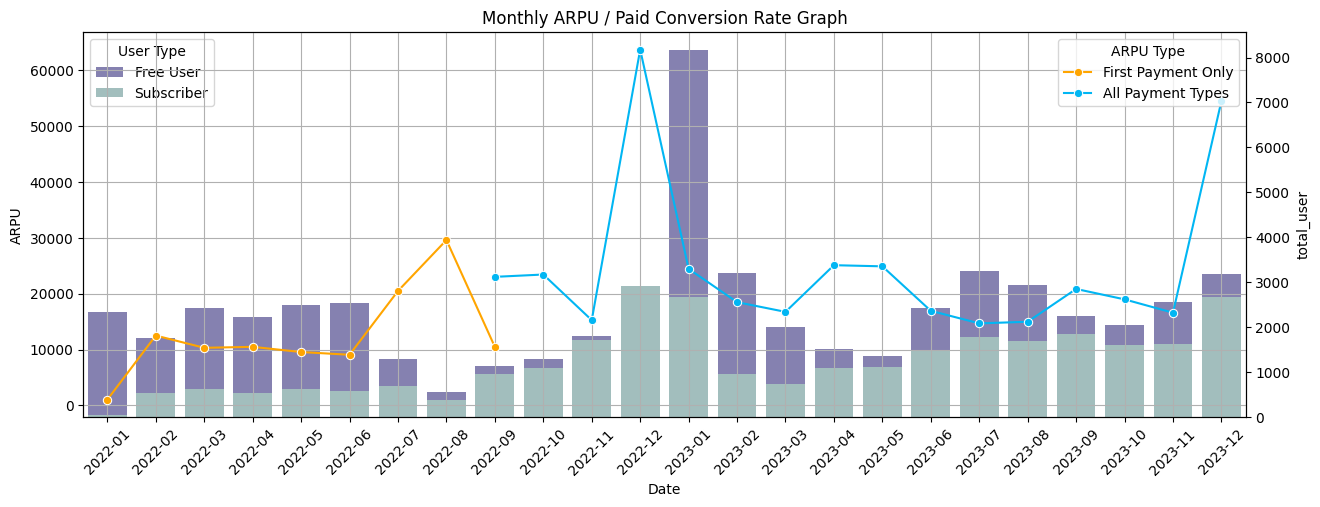

In [154]:
# 그래프 초기화
fig, ax3 = plt.subplots(figsize=(15, 5))

# 라인 그래프 생성
sns.lineplot(data=separated_arpu_2_df, x='period', y='ARPU', marker='o', ax=ax3, color='orange', label='First Payment Only')
sns.lineplot(data=separated_arpu_1_df, x='period', y='ARPU', marker='o', ax=ax3, color='#01b6f3', label='All Payment Types')

# 보조 그래프바 생성
ax4 = ax3.twinx()

# 바 그래프 생성
sns.barplot(data=concat_groupby_tmp[:-1], x='period', y='total_user', ax=ax4, color='#7e79b8', label='Free User')
sns.barplot(data=concat_groupby_tmp[:-1], x='period', y='subscriber', ax=ax4, color='#9dc3c1', label='Subscriber')

# 조더 값 조정 및 그리드 생성
ax3.set_zorder(3)
ax4.set_zorder(2)
ax3.grid(True, zorder=0)

# 라벨값 및 타이틀 생성
ax3.set_xlabel('Date')
ax3.set_ylabel('ARPU')
plt.title('Monthly ARPU / Paid Conversion Rate Graph')

# x-label의 각 값들을 회전
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45)

# 투명하게 만들어서 grid가 보이도록 설정
ax3.patch.set_visible(False)

legend2 = ax3.legend(title='ARPU Type', loc='upper right')
legend2 = ax4.legend(title='User Type', loc='upper left')

# 그래프 출력
plt.show()

---
### 일단 분리

In [2]:
# 데이터 불러오기
complete_subscription_df = complete.subscription()
renew_subscription_df = renew.subscription()
resubscribe_df = resubscribe.subscription()

In [29]:
# 함수 정의

# period 변환 함수
def change_period(data):
    data = data.copy()
    data['period'] = data['client_event_time'].dt.to_period('M')
    
    return data

# groupby 함수
def groupby(data):
    # 유료 사용자를 기준으로 집계
    data = data.groupby('period').agg(
        total_paid_amount = ('paid_amount', 'sum'),  # 총 유료 금액
        total_count = ('user_id', 'count'),  # 전체 결제 건 수
        total_user = ('user_id', 'nunique'), # 전체 유저 수
        one_month_plan_user = ('plan.price', lambda x: x[x.isin([15920])].sum()),  # 1개월 플랜 사용자
        three_month_plan_user = ('plan.price', lambda x: (x[x.isin([42960])]/3).sum()),  # 3개월 플랜 사용자
        one_year_plan_user = ('plan.price', lambda x: (x[x.isin([131600])]/12).sum()),  # 1년 플랜 사용자
        promotion_plan_user = ('plan.price', lambda x: (x[x.isin([79200, 95520, 95200, 91200, 87200, 83200])]/12).sum()),  # 프로모션 플랜 사용자
    )
    return data


In [30]:
# 모든 결제 완료 이력
concat_df = pd.concat([complete_subscription_df, renew_subscription_df, resubscribe_df], axis=0)

# 필요한 데이터 컬럼만 추출
concat_df = concat_df[['user_id', 'client_event_time', 'event_type', 'plan.price', 'paid_amount']]

# Data Type 변경
concat_df['client_event_time'] = pd.to_datetime(concat_df['client_event_time']) + pd.Timedelta(hours=9)
concat_df['client_event_time'] = concat_df['client_event_time'].dt.date

# 특정한 열에 중복값이 있는지 체크 후 첫번째 값만 남기고 제거
concat_df = concat_df.drop_duplicates(subset=['user_id', 'client_event_time', 'paid_amount'], keep='first')

# 날짜 비교를 위한 데이터 재변환
concat_df['client_event_time'] = pd.to_datetime(concat_df['client_event_time'])

# 데이터 확인
display(concat_df)

,user_id,client_event_time,event_type,plan.price,paid_amount
0,1116a2ae90ca6b06f85feba27ad51ef0,2023-04-06,complete.subscription,15920,15920
1,c0f5678df8967163e6e2c464ed006791,2023-04-10,complete.subscription,131600,131600
2,79421b5d038205ad7adbb1e2c3b89741,2023-03-12,complete.subscription,131600,119756
3,bdffe1f18684704d4ea2d7eebcaed180,2023-04-12,complete.subscription,131600,131600
4,d4f54ecf6c4d7bf8742f80505f02d6dc,2023-05-31,complete.subscription,15920,15920
...,...,...,...,...,...
786,482cf2ed1eefbe648ce156e43d323114,2023-10-21,resubscribe.subscription,15920,15920
787,b6b9428216580dbdc053e0bb19083be1,2023-07-31,resubscribe.subscription,15920,15920
788,eaff98093acb9a109975957cafb2d105,2023-12-31,resubscribe.subscription,95520,95520
789,e6aace24ed8703d42ce43c4b8b1c7d66,2023-12-29,resubscribe.subscription,95520,95520


In [32]:
# complete.subscription, renew.subscription, resubscibe.subscription의 데이터가 모두 존재하는 부분을 분리
separated_df1 = concat_df[(concat_df['client_event_time'] >= '2022-09-08') & (concat_df['client_event_time'] <= '2024-01-01')]

# complete.subscription만 존재하는 데이터 분리
separated_df2 = concat_df[concat_df['client_event_time'] < '2022-09-08']

In [33]:
# 분리된 데이터 리스트 저장
list_df = [separated_df1, separated_df2]

# 임시용 보관 데이터 생성
list_groupby = []

for i in range(len(list_df)):
    # Month period 타입 변환
    month_df = change_period(list_df[i])

    # groupby 및 reset_index()
    df_groupby = groupby(month_df).reset_index()

    # 데이터 타입 변환
    df_groupby['period'] = df_groupby['period'].dt.to_timestamp()

    # 리스트에 저장
    list_groupby.append(df_groupby)
    
# 결과 저장
separated_df1_month, separated_df2_month = list_groupby

# 데이터 확인
for list in list_groupby:
    display(list)

,period,total_paid_amount,total_count,total_user,one_month_plan_user,three_month_plan_user,one_year_plan_user,promotion_plan_user
0,2022-09-01,24248427,922,918,11382800,2205280.0,5.812333e+05,0.000000e+00
1,2022-10-01,30143986,1106,1097,12751920,3522720.0,6.470333e+05,0.000000e+00
2,2022-11-01,27486958,1727,1721,24086960,2219600.0,6.470333e+05,0.000000e+00
3,2022-12-01,185734071,2964,2906,11366880,1245840.0,0.000000e+00,1.427580e+07
4,2023-01-01,199342010,2709,2677,7753040,1374720.0,0.000000e+00,1.558227e+07
5,2023-02-01,59286291,979,967,8644560,1031040.0,3.991867e+06,0.000000e+00
6,2023-03-01,33452804,759,738,8469440,716000.0,1.930133e+06,0.000000e+00
7,2023-04-01,38089315,1089,1081,13866320,658720.0,1.886267e+06,0.000000e+00
8,2023-05-01,33894113,1109,1105,14853360,501200.0,1.458567e+06,0.000000e+00
9,2023-06-01,41067210,1480,1470,20632320,415280.0,1.634033e+06,0.000000e+00


,period,total_paid_amount,total_count,total_user,one_month_plan_user,three_month_plan_user,one_year_plan_user,promotion_plan_user
0,2022-01-01,2466721,54,54,318400,372320.0,8.773333e+04,0.0
1,2022-02-01,21949193,535,531,4951120,1904560.0,9.979667e+05,0.0
2,2022-03-01,25090147,652,633,6399840,1990480.0,1.217300e+06,0.0
3,2022-04-01,23275321,562,544,5094400,1918880.0,1.184400e+06,0.0
4,2022-05-01,23804028,632,617,5747120,2477360.0,1.074733e+06,0.0
5,2022-06-01,23111595,602,583,5444640,2377120.0,1.030867e+06,0.0
6,2022-07-01,26527391,710,691,6845600,2405760.0,1.228267e+06,0.0
7,2022-08-01,16304670,399,383,3757120,1188560.0,8.773333e+05,0.0
8,2022-09-01,1697591,50,50,525360,171840.0,5.483333e+04,0.0


In [34]:
# 데이터 초기화
arppu_list = []

# ARPPU 계산
for list in list_groupby:
    list['ARPPU'] = round(list['total_paid_amount'] / list['total_user'], 2)
    arppu_list.append(list)

# 데이터 확인
for list in arppu_list:
    display(list)

,period,total_paid_amount,total_count,total_user,one_month_plan_user,three_month_plan_user,one_year_plan_user,promotion_plan_user,ARPPU
0,2022-09-01,24248427,922,918,11382800,2205280.0,5.812333e+05,0.000000e+00,26414.41
1,2022-10-01,30143986,1106,1097,12751920,3522720.0,6.470333e+05,0.000000e+00,27478.57
2,2022-11-01,27486958,1727,1721,24086960,2219600.0,6.470333e+05,0.000000e+00,15971.50
3,2022-12-01,185734071,2964,2906,11366880,1245840.0,0.000000e+00,1.427580e+07,63914.00
4,2023-01-01,199342010,2709,2677,7753040,1374720.0,0.000000e+00,1.558227e+07,74464.70
5,2023-02-01,59286291,979,967,8644560,1031040.0,3.991867e+06,0.000000e+00,61309.50
6,2023-03-01,33452804,759,738,8469440,716000.0,1.930133e+06,0.000000e+00,45329.00
7,2023-04-01,38089315,1089,1081,13866320,658720.0,1.886267e+06,0.000000e+00,35235.26
8,2023-05-01,33894113,1109,1105,14853360,501200.0,1.458567e+06,0.000000e+00,30673.41
9,2023-06-01,41067210,1480,1470,20632320,415280.0,1.634033e+06,0.000000e+00,27936.88


,period,total_paid_amount,total_count,total_user,one_month_plan_user,three_month_plan_user,one_year_plan_user,promotion_plan_user,ARPPU
0,2022-01-01,2466721,54,54,318400,372320.0,8.773333e+04,0.0,45680.02
1,2022-02-01,21949193,535,531,4951120,1904560.0,9.979667e+05,0.0,41335.58
2,2022-03-01,25090147,652,633,6399840,1990480.0,1.217300e+06,0.0,39636.88
3,2022-04-01,23275321,562,544,5094400,1918880.0,1.184400e+06,0.0,42785.52
4,2022-05-01,23804028,632,617,5747120,2477360.0,1.074733e+06,0.0,38580.27
5,2022-06-01,23111595,602,583,5444640,2377120.0,1.030867e+06,0.0,39642.53
6,2022-07-01,26527391,710,691,6845600,2405760.0,1.228267e+06,0.0,38389.86
7,2022-08-01,16304670,399,383,3757120,1188560.0,8.773333e+05,0.0,42570.94
8,2022-09-01,1697591,50,50,525360,171840.0,5.483333e+04,0.0,33951.82


In [35]:
# ARPPU 그래프 생성 전 전처리 작업란
# period x열 생성을 위한 병합
merged_df = pd.merge(
    arppu_list[0],
    arppu_list[1],
    on='period', how='outer',
    suffixes=('_df1', '_df2'))

# period를 string으로 변환
merged_df['period'] = merged_df['period'].dt.strftime('%Y-%m')

# '2024-01' 데이터 제거
merged_df = merged_df[merged_df['period'] != '2024-01']

# 데이터 확인
display(merged_df)

,period,total_paid_amount_df1,total_count_df1,total_user_df1,one_month_plan_user_df1,three_month_plan_user_df1,one_year_plan_user_df1,promotion_plan_user_df1,ARPPU_df1,total_paid_amount_df2,total_count_df2,total_user_df2,one_month_plan_user_df2,three_month_plan_user_df2,one_year_plan_user_df2,promotion_plan_user_df2,ARPPU_df2
0,2022-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2466721.0,54.0,54.0,318400.0,372320.0,8.773333e+04,0.0,45680.02
1,2022-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21949193.0,535.0,531.0,4951120.0,1904560.0,9.979667e+05,0.0,41335.58
2,2022-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25090147.0,652.0,633.0,6399840.0,1990480.0,1.217300e+06,0.0,39636.88
3,2022-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23275321.0,562.0,544.0,5094400.0,1918880.0,1.184400e+06,0.0,42785.52
4,2022-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23804028.0,632.0,617.0,5747120.0,2477360.0,1.074733e+06,0.0,38580.27
5,2022-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23111595.0,602.0,583.0,5444640.0,2377120.0,1.030867e+06,0.0,39642.53
6,2022-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26527391.0,710.0,691.0,6845600.0,2405760.0,1.228267e+06,0.0,38389.86
7,2022-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16304670.0,399.0,383.0,3757120.0,1188560.0,8.773333e+05,0.0,42570.94
8,2022-09,24248427.0,922.0,918.0,11382800.0,2205280.0,5.812333e+05,0.000000e+00,26414.41,1697591.0,50.0,50.0,525360.0,171840.0,5.483333e+04,0.0,33951.82
9,2022-10,30143986.0,1106.0,1097.0,12751920.0,3522720.0,6.470333e+05,0.000000e+00,27478.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
# Subscribe Plan Count 그래프 생성 전 전처리 작업란
# melt()를 이용하여 데이터 변환 후 중복된 period 값 합산
temp_list = []
for i in range(2):
    name1 = f'one_month_plan_user_df{i+1}'
    name2 = f'three_month_plan_user_df{i+1}'
    name3 = f'one_year_plan_user_df{i+1}'
    name4 = f'promotion_plan_user_df{i+1}'

    data = merged_df.melt(
        id_vars='period',
        value_vars=[name1, name2, name3, name4],
        var_name='plan_type',
        value_name='user_count')

    # 'df1'과 'df2'를 제거한 새로운 plan_type을 생성
    data['plan_type'] = data['plan_type'].str.replace('_df1', '').str.replace('_df2', '')

    # '2024-01' 데이터 제거
    data = data[data['period'] != '2024-01']

    temp_list.append(data)

# 두 데이터프레임을 합치고 동일한 period와 plan_type 값을 그룹화하여 합산
subscribe_plan_df = pd.concat(temp_list).groupby(['period', 'plan_type']).sum().reset_index()

# 데이터 확인
display(subscribe_plan_df)

,period,plan_type,user_count
0,2022-01,one_month_plan_user,3.184000e+05
1,2022-01,one_year_plan_user,8.773333e+04
2,2022-01,promotion_plan_user,0.000000e+00
3,2022-01,three_month_plan_user,3.723200e+05
4,2022-02,one_month_plan_user,4.951120e+06
...,...,...,...
91,2023-11,three_month_plan_user,2.148000e+05
92,2023-12,one_month_plan_user,1.697072e+07
93,2023-12,one_year_plan_user,1.337933e+06
94,2023-12,promotion_plan_user,1.176488e+07


C:\Users\lento\AppData\Local\Temp\ipykernel_24132\2321638802.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
C:\Users\lento\AppData\Local\Temp\ipykernel_24132\2321638802.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  legend2 = ax1.legend( title='ARPPU Type', loc='upper right')


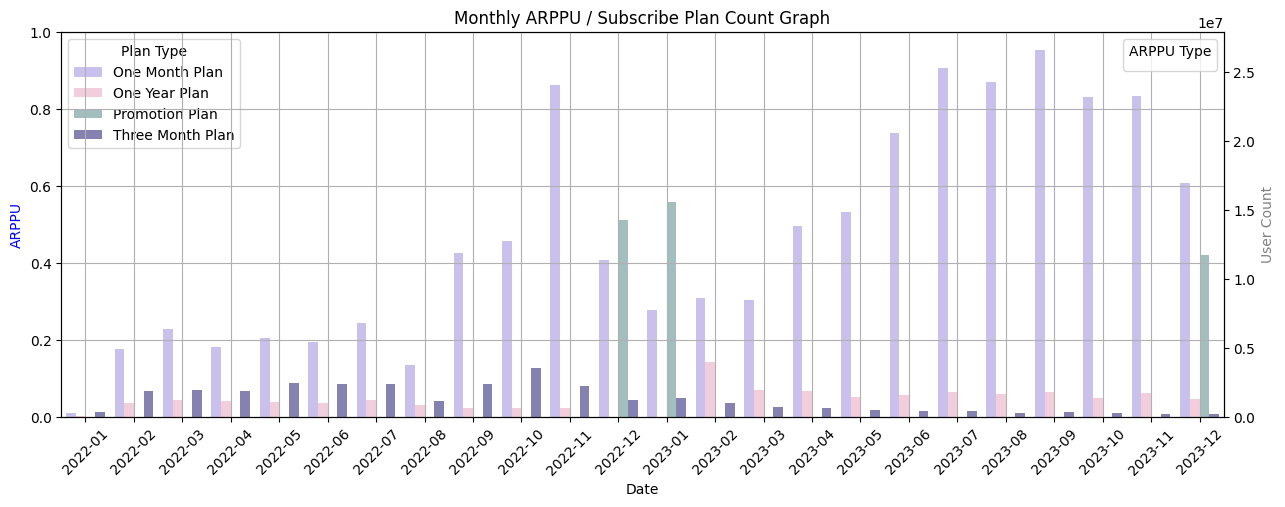

In [37]:
# 그래프 생성
fig, ax1 = plt.subplots(figsize=(15, 5))

# 라인 플롯
# sns.lineplot(x=merged_df['period'], y=merged_df['ARPPU_df1'], marker='o', ax=ax1, label='All Payment Types', color='#a26cf3')
# sns.lineplot(x=merged_df['period'], y=merged_df['ARPPU_df2'], marker='o', ax=ax1, label='First Payment Only', color='#01b6f3')

# 바 플롯을 보조로 사용하기 위한 준비
ax2 = ax1.twinx()

# 색상 설정
plan_colors = {
    'one_month_plan_user': '#c5b9f2', 
    'three_month_plan_user': '#7e79b8', 
    'one_year_plan_user': '#f8c8dc', 
    'promotion_plan_user': '#9dc3c1'
}

# 바 플롯 그리기 (색상 지정 및 alpha 조정)
sns.barplot(x='period', y='user_count', hue='plan_type', data=subscribe_plan_df, ax=ax2, palette=plan_colors)

# zorder 조정
ax1.set_zorder(3)
ax2.set_zorder(2)
ax1.grid(True, zorder=0)

# 라벨 및 제목 설정
ax1.set_xlabel('Date')
ax1.set_ylabel('ARPPU', color='b')
ax2.set_ylabel('User Count', color='gray')
plt.title('Monthly ARPPU / Subscribe Plan Count Graph')

# x축 회전
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

# 투명하게 만들어서 grid가 보이도록 설정
ax1.patch.set_visible(False)

# 범례 수동으로 설정 (색상과 항목이 매칭되도록)
handles, labels = ax2.get_legend_handles_labels()
legend2 = ax1.legend( title='ARPPU Type', loc='upper right')
legend2 = ax2.legend(handles=handles, labels=['One Month Plan', 'One Year Plan', 'Promotion Plan', 'Three Month Plan'], title='Plan Type', loc='upper left')

# 범례 최상단 배치
legend2.set_zorder(4)

plt.show()

In [4]:
enter_main_page_df = enter.main_page()

In [4]:
# 비회원이 main_page에 접속한 빈도 상위 15개 OS 
enter_main_page_df[enter_main_page_df['user_id'].isnull()]['os_name'].value_counts().head(15)

os_name
Chrome             658242
Mobile Safari      224270
Instagram          198313
Samsung Browser    107053
Edge                87097
Chrome WebView      66835
Whale               66410
Chrome Mobile       48206
Safari              47874
WebKit              47631
Facebook            37220
GSA                 10788
Firefox              3870
Chrome Headless      2775
Opera                 973
Name: count, dtype: int64

In [5]:
# 국가별 main_page에 접속한 빈도 상위 15개 국가
enter_main_page_df['country'].value_counts().head(15)

country
South Korea       2079303
United States       18925
Japan                5329
Canada               4142
Germany              3009
Ireland              2144
Australia            1970
Singapore            1736
United Kingdom       1688
Vietnam              1317
India                1216
France               1014
Hong Kong             970
China                 784
Thailand              524
Name: count, dtype: int64

In [6]:
# 각 국가별 main_page에 접속한 OS 비율
enter_main_page_df.groupby

<bound method DataFrame.groupby of                   city           client_event_time      country  \
0          Seongnam-si  2023-04-05 21:55:06.140000  South Korea   
1        Dongdaemun-gu  2023-04-05 21:04:28.967000  South Korea   
2          Hwaseong-si  2023-04-05 21:01:31.258000  South Korea   
3          Hwaseong-si  2023-04-05 21:02:50.374000  South Korea   
4                Seoul  2023-04-05 21:30:33.727000  South Korea   
...                ...                         ...          ...   
2133543       Jeongeup  2023-10-10 05:53:29.283000  South Korea   
2133544       Jeongeup  2023-10-10 05:54:17.572000  South Korea   
2133545     Gangnam-gu  2023-10-10 05:54:33.164000  South Korea   
2133546        Saha-gu  2023-10-10 05:58:15.175000  South Korea   
2133547          Seoul  2023-10-10 05:58:45.857000  South Korea   

         device_carrier        device_family                device_type  \
0                   NaN        Samsung Phone      Samsung Galaxy S21 5G   
1         

In [2]:
enter_content_page_df = enter.content_page()
start_free_trial_df = start.free_trial()
complete_subscription_df = complete.subscription()
renew_subscription_df = renew.subscription()
resubscribe_df = resubscribe.subscription()
start_content_df = start.content()

In [96]:
# 모든 결제 완료 이력
concat_df = pd.concat([complete_subscription_df, renew_subscription_df, resubscribe_df], axis=0)
concat_df = concat_df.drop_duplicates()
concat_df

# data type 변경
concat_df['client_event_time'] = pd.to_datetime(concat_df['client_event_time'])

merge_df2 = pd.merge(concat_df, start_free_trial_df[['user_id', 'plan.type']], how='inner', on='user_id')
merge_df2 = merge_df2.drop_duplicates()
merge_df2.groupby(['plan.price', 'plan.type']).size().reset_index(name='count')

# 궁금점
concat_df.groupby('plan.price').agg(client_event_time_min=('client_event_time', 'min'), client_event_time_max=('client_event_time', 'max'))

,client_event_time_min,client_event_time_max
plan.price,,
14328,2023-05-02 07:50:46.978,2023-12-17 02:30:01.995
15920,2022-01-02 08:34:14.270,2023-12-31 09:20:02.770
19920,2023-03-16 01:59:11.035,2023-03-16 01:59:11.035
42960,2022-01-01 06:17:24.513,2023-12-30 09:20:05.551
79200,2022-11-30 15:11:19.442,2022-12-31 14:58:49.139
83200,2022-12-31 15:18:32.786,2023-01-10 14:59:10.551
87200,2023-01-10 15:04:31.960,2023-01-17 14:56:54.133
91200,2023-01-17 15:00:47.164,2023-01-24 14:58:37.499
95200,2023-01-24 15:00:07.569,2023-01-31 14:55:01.296


In [37]:
# 모든 결제 건 수 중 무료 체험을 시작한 후 결제한 유저의 값
merge_df = pd.merge(start_free_trial_df, concat_df, on='user_id', how='inner')
merge_df

,city_x,client_event_time_x,country_x,device_carrier_x,device_family_x,device_type_x,event_type_x,language_x,os_name_x,os_version_x,platform_x,user_id,plan.price_x,plan.type,trial.type,city_y,client_event_time_y,country_y,device_carrier_y,device_family_y,device_type_y,event_type_y,language_y,os_name_y,os_version_y,platform_y,plan.price_y,paid_amount,coupon.discount_amount,pg.type
0,NaN,2023-03-12 08:35:00.107000,NaN,NaN,NaN,NaN,start.free_trial,NaN,NaN,NaN,NaN,38aca03fba9753a6b2f31b829fb16a30,15920.0,1개월 플랜,B,Seoul,2023-03-19 08:35:01.854000,South Korea,NaN,Windows,Windows,complete.subscription,Korean,Chrome,111.0.0.0,Web,15920,15920,0,NaN
1,NaN,2023-03-12 08:35:00.107000,NaN,NaN,NaN,NaN,start.free_trial,NaN,NaN,NaN,NaN,38aca03fba9753a6b2f31b829fb16a30,15920.0,1개월 플랜,B,Seoul,2023-04-19 08:40:02.338,South Korea,NaN,Mac,Mac,renew.subscription,Korean,Chrome,111.0.0.0,Web,15920,15920,0,NaN
2,NaN,2023-03-12 08:35:00.107000,NaN,NaN,NaN,NaN,start.free_trial,NaN,NaN,NaN,NaN,38aca03fba9753a6b2f31b829fb16a30,15920.0,1개월 플랜,B,Suwon,2023-05-19 08:45:01.660,South Korea,NaN,Mac,Mac,renew.subscription,Korean,Chrome,112.0.0.0,Web,15920,15920,0,NaN
3,NaN,2023-03-12 08:35:00.107000,NaN,NaN,NaN,NaN,start.free_trial,NaN,NaN,NaN,NaN,38aca03fba9753a6b2f31b829fb16a30,15920.0,1개월 플랜,B,Guro-gu,2023-06-19 08:50:02.764,South Korea,NaN,Mac,Mac,renew.subscription,Korean,Chrome,114.0.0.0,Web,15920,15920,0,NaN
4,NaN,2023-03-12 08:35:00.107000,NaN,NaN,NaN,NaN,start.free_trial,NaN,NaN,NaN,NaN,38aca03fba9753a6b2f31b829fb16a30,15920.0,1개월 플랜,B,Seoul,2023-07-19 08:55:01.945,South Korea,NaN,Mac,Mac,renew.subscription,Korean,Chrome,114.0.0.0,Web,15920,15920,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14394,Hongseong-gun,2022-10-28 04:16:34.387000,South Korea,NaN,Windows,Windows,start.free_trial,Korean,Chrome,107.0,Web,3c55c67f1a2634bd2a38d4ee11daa650,NaN,NaN,A,Hongseong-gun,2022-11-04 04:20:02.926000,South Korea,NaN,Windows,Windows,complete.subscription,Korean,Chrome,107,Web,131600,131600,0,NaN
14395,Hongseong-gun,2022-10-28 04:16:34.387000,South Korea,NaN,Windows,Windows,start.free_trial,Korean,Chrome,107.0,Web,3c55c67f1a2634bd2a38d4ee11daa650,NaN,NaN,A,Hongseong-gun,2022-11-04 04:20:01.516,South Korea,NaN,Windows,Windows,renew.subscription,Korean,Chrome,107,Web,131600,131600,0,NaN
14396,Uiwang,2022-05-28 04:36:00.949000,South Korea,NaN,Windows,Windows,start.free_trial,Korean,Chrome,102.0,Web,4254765f174fe193cd90c093d73e62e8,NaN,NaN,A,Gwangmyeong,2022-05-31 05:14:36.838000,South Korea,NaN,Mac,Mac,complete.subscription,Korean,Chrome,101,Web,15920,13532,2388,NaN
14397,Uiwang,2022-05-28 04:36:32.423000,South Korea,NaN,Windows,Windows,start.free_trial,Korean,Chrome,102.0,Web,4254765f174fe193cd90c093d73e62e8,NaN,NaN,A,Gwangmyeong,2022-05-31 05:14:36.838000,South Korea,NaN,Mac,Mac,complete.subscription,Korean,Chrome,101,Web,15920,13532,2388,NaN


In [3]:
# 데이터 불러오기
click_content_page_start_content_btn_df = click.content_page_start_content_button()

# 데이터 타입 변환
click_content_page_start_content_btn_df['client_event_time'] = pd.to_datetime(click_content_page_start_content_btn_df['client_event_time'])

# 데이터 분리
type_a_df = click_content_page_start_content_btn_df[
    click_content_page_start_content_btn_df['button.name'].isnull() &\
    click_content_page_start_content_btn_df['button_name'].notnull()]
type_b_df = click_content_page_start_content_btn_df[
    click_content_page_start_content_btn_df['button.name'].notnull() &\
    click_content_page_start_content_btn_df['button_name'].isnull()]

# 데이터 확인
print("Type A 날짜 범위")
print(type_a_df.groupby('button_name').agg(min_time=('client_event_time', 'min'), max_time=('client_event_time', 'max')))
print("\n")
print("Type B 날짜 범위")
print(type_b_df.groupby('button.name').agg(min_time=('client_event_time', 'min'), max_time=('client_event_time', 'max')))

NameError: name 'click' is not defined

In [49]:
complete_signup_df = complete.signup()
start_free_trial_df = start.free_trial()
start_content_df = start.content()

complete_subscription_df = complete.subscription()

In [ ]:
# signup 데이터와 free_trial 데이터 병합
merge_df1 = pd.merge(
    complete_signup_df[['user_id', 'client_event_time']],
    start_free_trial_df[['user_id', 'client_event_time']],
    how='left',
    on='user_id',
    suffixes=('_signup', '_free_trial')
)

# 이전에 병합한 데이터에 complete_subscription 데이터 병합
merge_df2 = pd.merge(
    merge_df1,
    complete_subscription_df[['user_id', 'client_event_time']],
    how='left',
    on='user_id'
)

# 이전에 병합한 데이터에 start_content 데이터 병합
merge_df3 = pd.merge(
    merge_df2,
    start_content_df[['user_id', 'client_event_time']],
    how='left',
    on='user_id')

# 중복값 제거
merge_df3 = merge_df3.drop_duplicates()

# 데이터 컬럼명 재정의
merge_df3.rename(columns={
    'client_event_time_signup': 'signup_time',
    'client_event_time_free_trial': 'free_trial_time',
    'client_event_time_x': 'subscription_time',
    'client_event_time_y': 'content_time'
}, inplace=True)

merge_df3

# user_id로 묶은 뒤 각 행들의 첫번째 값들만 뽑아오기
merge_groupby = merge_df3.groupby('user_id').agg({
    'signup_time' : 'first',
    'subscription_time' : 'first',
    'free_trial_time' : 'first',
    'content_time' : 'first'
})

merge_groupby = merge_groupby.reset_index()

merge_groupby # 145133 rows × 3 columns (수정 별도로 필요)

# content_time이 결측치인 값을 제거
merge_groupby.dropna(subset=['content_time']) # 36388 rows × 4 columns

merge_groupby

# # 활성화 무료 유저 : 36388명

,user_id,signup_time,subscription_time,free_trial_time,content_time
0,0000572f2ba8079bcefd2760b632e820,2023-03-18 10:33:16.237000,2023-03-25 14:40:01.647000,2023-03-18 14:39:22.844000,2023-03-18 16:49:45.361000
1,000087537cbfd934375364218ff10f91,2023-03-27 04:54:01.257000,2023-04-08 11:45:01.586000,2023-04-01 11:42:25.489000,2023-05-01 10:31:15.918000
2,000117267e1dd62481ef3ae7fb420107,2022-12-16 05:05:24.926000,None,None,None
3,0001f15911b404f3bf5b8571afafa4e4,2023-11-19 02:53:43.023000,2023-11-29 01:13:51.820000,None,2023-11-22 12:50:00.941000
4,0001f28a707789a7d78dc28fd2e84dce,2023-10-15 15:09:34.334000,None,None,None
...,...,...,...,...,...
145128,fffe529de03d6187ef7ed765650c8d2b,2023-02-26 13:40:51.953000,None,2023-03-01 12:37:09.512000,2023-05-02 08:10:35.470000
145129,fffee4d401b390a681491b9f5cfe40fb,2023-12-31 07:37:01.064000,None,None,None
145130,fffef868442fc8f4f405894b8ff8959f,2023-07-03 04:52:16.228000,None,None,None
145131,ffffd8d78865a66cb3706977f29d1dec,2023-09-11 10:06:34.388000,None,None,2023-11-15 04:45:32.896000


In [2]:
enter_main_page_df = enter.main_page()

In [3]:
print(enter_main_page_df[enter_main_page_df['device_type'] == 'Windows'].shape[0])
print(enter_main_page_df[enter_main_page_df['device_type'] == 'Mac'].shape[0])
print(enter_main_page_df[enter_main_page_df['device_type'] == 'Linux'].shape[0])
print(enter_main_page_df[enter_main_page_df['device_type'] == 'Ubuntu'].shape[0])

845411
233654
16489
143


In [4]:
enter_main_page_df[(enter_main_page_df['device_family'].str.contains('-') == False) &
                   (enter_main_page_df['device_family'].str.contains('_') == False) &
                   (enter_main_page_df['device_family'].str.contains(r'\d') == False) &
                   (enter_main_page_df['device_family'].str.contains('Phone') == False) &
                   (enter_main_page_df['device_family'].str.contains('TV') == False) &
                   (enter_main_page_df['device_family'].str.contains('Tablet') == False) &
                   (enter_main_page_df['device_family'].str.contains('Mobile') == False) &
                   (enter_main_page_df['device_family'].str.contains('Android') == False) &
                   (enter_main_page_df['device_family'].str.contains('Samsung') == False) &
                   (enter_main_page_df['device_family'].str.contains('Apple') == False)]['device_family'].unique()

array(['Mac', 'Windows', 'Linux', 'K', 'CentOS', 'Chromium OS', 'Ubuntu',
       'LG lge', 'Tesla Linux', 'HiPad X', 'Microsoft Xbox One',
       'Xiaomi MID', 'wv', 'Fedora', 'AOSP on flame', 'iOS', 'Active',
       '<Device Model>', 'LG Linux', 'Amazon Kindle', 'DTABPLUS',
       'BISON GT', 'Microsoft Surface Duo', 'Titan', 'Tizen',
       'BlackBerry', 'BISON Pro', 'Sony Xperia', 'Motorola razr',
       'DEVICE INFO', 'walleye', 'tablePC', 'MASTERPRO', 'NovaAirC',
       'BRAVE'], dtype=object)

In [85]:
complete_signup_df = complete.signup()
start_free_trial_df = start.free_trial()
complete_subscription_df = complete.subscription()
renew_subscription_df = renew.subscription()
resubscribe_df = resubscribe.subscription()
cancel_plan_df = click.cancel_plan_button()

In [86]:
# 데이터 concat
concat_df = pd.concat([
    complete_signup_df[['user_id', 'client_event_time', 'event_type']],
    start_free_trial_df[['user_id', 'client_event_time', 'event_type']],
    complete_subscription_df[['user_id', 'client_event_time', 'event_type']],
    renew_subscription_df[['user_id', 'client_event_time', 'event_type']],
    resubscribe_df[['user_id', 'client_event_time', 'event_type']],
    cancel_plan_df[['user_id', 'client_event_time', 'event_type']]], axis=0).reset_index(drop=True)

# 데이터 타입 변경
concat_df['client_event_time'] = pd.to_datetime(concat_df['client_event_time']) + pd.DateOffset(hours=9)

# user_id 컬럼 결측치 제거
concat_df = concat_df.dropna(subset=['user_id'])

# 데이터 기한 설정
concat_df = concat_df[(concat_df['client_event_time'] >= '2022-01-01') & (concat_df['client_event_time'] < '2023-05-01')]

# client_event_time 오름차순 정렬
concat_df = concat_df.sort_values(by='client_event_time').reset_index(drop=True)

# 데이터 확인
concat_df

,user_id,client_event_time,event_type
0,6b4b4d8e08ce009f8992c546372ce664,2022-01-01 09:06:31.232,complete.signup
1,a5b72d5c6dd4e213315225d9fb9bbbca,2022-01-01 09:10:21.400,complete.signup
2,81c52556d0605b8221aa897cd2ed740d,2022-01-01 09:10:49.730,complete.signup
3,4a8e9325b1a855be259d7dad2d378276,2022-01-01 09:12:18.251,complete.signup
4,e98481d6081c560ad6c9c01c4596129e,2022-01-01 09:17:55.165,start.free_trial
...,...,...,...
148542,7ca10d40675592dbacde558dcebfb501,2023-04-30 23:48:54.989,complete.signup
148543,a01b3ae7f1817ebd60860f3fcd5e40c5,2023-04-30 23:51:16.178,complete.signup
148544,95cfd6728d7b510b5ad18e8e16fdc672,2023-04-30 23:55:01.850,complete.subscription
148545,cea0d65cbcd9005a6a4e66b5f39aa5e7,2023-04-30 23:56:40.414,start.free_trial


In [87]:
concat_df['user_id'].nunique()

96072

In [88]:
trial_list = []
non_trial_list = []

for user_id in concat_df['user_id'].unique():
    user_df = concat_df[concat_df['user_id'] == user_id]
    
    if 'complete.signup' in user_df['event_type'].values:
        if ('start.free_trial' in user_df['event_type'].values) & ('complete.subscription' in user_df['event_type'].values):
            trial_list.append(user_df)
        if ('start.free_trial' not in user_df['event_type'].values) & ('complete.subscription' in user_df['event_type'].values):
            non_trial_list.append(user_df)

# 최종 데이터 병합
trial_df = pd.concat(trial_list, ignore_index=True)
non_trial_df = pd.concat(non_trial_list, ignore_index=True)

In [89]:
trial_df['user_id'].nunique()

3015

In [90]:
# 무료체험을 하고 구독한 유저의 타임라인 데이터프레임 작업란
resubs_time_list1 = []
cancel_time_list1 = []

for user_id in trial_df['user_id'].unique():
    user_df = trial_df[trial_df['user_id'] == user_id]
    
    # resubscribe.subscription 계산
    if 'resubscribe.subscription' in user_df['event_type'].values:
        user_df = user_df.sort_values(by='client_event_time')  # 시간 순 정렬
        user_df['prev_client_event_time'] = user_df['client_event_time'].shift(1)  # 이전 이벤트 시간 추가
        
        resubs_time = user_df.loc[user_df['event_type'] == 'resubscribe.subscription', 'client_event_time'] - \
                      user_df.loc[user_df['event_type'] == 'resubscribe.subscription', 'prev_client_event_time']
        
        # NaN 값 제거 후 리스트에 추가
        resubs_time_list1.extend(resubs_time.dt.days.dropna().tolist())

    # click.cancel_plan_button 계산
    if 'click.cancel_plan_button' in user_df['event_type'].values and 'complete.signup' in user_df['event_type'].values:
        signup_time = user_df.loc[user_df['event_type'] == 'complete.signup', 'client_event_time'].min()  # 첫 구독 시간
        cancel_times = user_df.loc[user_df['event_type'] == 'click.cancel_plan_button', 'client_event_time']
        
        cancel_time_diff = (cancel_times - signup_time).dt.days.dropna()
        cancel_time_list1.extend(cancel_time_diff.tolist())

# 평균 계산 (0으로 나누는 경우 방지)
avg_resubs_time1 = sum(resubs_time_list1) / len(resubs_time_list1) if resubs_time_list1 else 0
avg_cancel_time1 = sum(cancel_time_list1) / len(cancel_time_list1) if cancel_time_list1 else 0

In [91]:
print(f"무료 체험을 한 유저의 수 : {trial_df['user_id'].nunique()}명")
print(f"그 중 만료 뒤 재구독을 한 유저의 수 : {trial_df[trial_df['event_type'] == 'resubscribe.subscription']['user_id'].nunique()}명")
print(f"그 중 구독을 취소한 유저의 수 : {trial_df[trial_df['event_type'] == 'click.cancel_plan_button']['user_id'].nunique()}명")
print(f"평균 만료 후 재 구독 경과 시간 : {avg_resubs_time1:.2f}일")
print(f"취소 시 첫 구독 이래 이용한 평균 시간 : {avg_cancel_time1:.2f}일")

무료 체험을 한 유저의 수 : 3015명
그 중 만료 뒤 재구독을 한 유저의 수 : 36명
그 중 구독을 취소한 유저의 수 : 1868명
평균 만료 후 재 구독 경과 시간 : 110.36일
취소 시 첫 구독 이래 이용한 평균 시간 : 88.92일


In [92]:
non_trial_df['user_id'].nunique()

4928

In [93]:
# 무료체험을 하지 않고 구독한 유저의 타임라인 데이터프레임 작업란
resubs_time_list2 = []
cancel_time_list2 = []

for user_id in non_trial_df['user_id'].unique():
    user_df = non_trial_df[non_trial_df['user_id'] == user_id].copy()
    
    # resubscribe.subscription 계산
    if 'resubscribe.subscription' in user_df['event_type'].values:
        user_df = user_df.sort_values(by='client_event_time')  # 시간 순 정렬
        user_df['prev_client_event_time'] = user_df['client_event_time'].shift(1)  # 이전 이벤트 시간 추가
        
        resubs_time = user_df.loc[user_df['event_type'] == 'resubscribe.subscription', 'client_event_time'] - \
                      user_df.loc[user_df['event_type'] == 'resubscribe.subscription', 'prev_client_event_time']
        
        # NaN 값 제거 후 리스트에 추가
        resubs_time_list2.extend(resubs_time.dt.days.dropna().tolist())

    # click.cancel_plan_button 계산
    if 'click.cancel_plan_button' in user_df['event_type'].values and 'complete.signup' in user_df['event_type'].values:
        signup_time = user_df.loc[user_df['event_type'] == 'complete.signup', 'client_event_time'].min()  # 첫 구독 시간
        cancel_times = user_df.loc[user_df['event_type'] == 'click.cancel_plan_button', 'client_event_time']
        
        cancel_time_diff = (cancel_times - signup_time).dt.days.dropna()
        cancel_time_list2.extend(cancel_time_diff.tolist())

# 평균 계산 (0으로 나누는 경우 방지)
avg_resubs_time2 = sum(resubs_time_list2) / len(resubs_time_list2) if resubs_time_list2 else 0
avg_cancel_time2 = sum(cancel_time_list2) / len(cancel_time_list2) if cancel_time_list2 else 0

In [94]:
print(f"무료 체험을 한 유저의 수 : {non_trial_df['user_id'].nunique()}명")
print(f"그 중 만료 뒤 재구독을 한 유저의 수 : {non_trial_df[non_trial_df['event_type'] == 'resubscribe.subscription']['user_id'].nunique()}명")
print(f"그 중 구독을 취소한 유저의 수 : {non_trial_df[non_trial_df['event_type'] == 'click.cancel_plan_button']['user_id'].nunique()}명")
print(f"평균 만료 후 재 구독 경과 시간 : {avg_resubs_time2:.2f}일")
print(f"취소 시 첫 구독 이래 이용한 평균 시간 : {avg_cancel_time2:.2f}일")

무료 체험을 한 유저의 수 : 4928명
그 중 만료 뒤 재구독을 한 유저의 수 : 41명
그 중 구독을 취소한 유저의 수 : 2320명
평균 만료 후 재 구독 경과 시간 : 98.62일
취소 시 첫 구독 이래 이용한 평균 시간 : 77.28일


In [66]:
enter_main_page_df = enter.main_page()

In [67]:
class desktop_mobile_filter: 
    def __init__(self, class_name):
        self.class_name = class_name
    
    @staticmethod
    def desktop(data):
        desktop_columns = ((data['device_family'].str.contains('Windows')) | (data['device_family'].str.contains('Mac')))
        return desktop_columns
    
    @staticmethod
    def mobile(data):
        mobile_columns = ((data['device_family'].str.contains('Samsung')) |
                          (data['device_family'].str.contains('LG')) |
                          (data['device_family'].str.contains('Apple')) |
                          (data['device_family'] == 'Android') |
                          (data['device_family'] == 'iOS'))
        return mobile_columns

In [68]:
enter_main_page_df[desktop_mobile_filter.desktop(enter_main_page_df)]

,city,client_event_time,country,device_carrier,device_family,device_type,event_type,language,os_name,os_version,platform,user_id
1,Dongdaemun-gu,2023-04-05 21:04:28.967000,South Korea,NaN,Mac,Mac,enter.main_page,Korean,Chrome,111.0.0.0,Web,b2b31f00b82edc6419b25324a7ae41a4
8,Jung-gu,2023-04-05 21:55:29.031000,South Korea,NaN,Windows,Windows,enter.main_page,Korean,Chrome,111.0.0.0,Web,NaN
14,Wonju,2023-04-05 21:44:18.121000,South Korea,NaN,Windows,Windows,enter.main_page,Korean,Chrome,111.0.0.0,Web,NaN
15,Seoul,2023-04-05 21:44:50.470000,South Korea,NaN,Mac,Mac,enter.main_page,Korean,Safari,15.6.1,Web,NaN
18,Naju,2023-04-05 21:50:39.168000,South Korea,NaN,Windows,Windows,enter.main_page,Korean,Firefox,111.0,Web,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2133540,Dongjak-gu,2023-10-10 05:57:19.646000,South Korea,NaN,Windows,Windows,enter.main_page,Korean,Edge,117.0.2045.60,Web,NaN
2133543,Jeongeup,2023-10-10 05:53:29.283000,South Korea,NaN,Windows,Windows,enter.main_page,Korean,Chrome,117.0.0.0,Web,NaN
2133544,Jeongeup,2023-10-10 05:54:17.572000,South Korea,NaN,Windows,Windows,enter.main_page,Korean,Chrome,117.0.0.0,Web,NaN
2133545,Gangnam-gu,2023-10-10 05:54:33.164000,South Korea,NaN,Windows,Windows,enter.main_page,Korean,Chrome,117.0.0.0,Web,NaN


In [69]:
enter_main_page_df[desktop_mobile_filter.mobile(enter_main_page_df)]

,city,client_event_time,country,device_carrier,device_family,device_type,event_type,language,os_name,os_version,platform,user_id
0,Seongnam-si,2023-04-05 21:55:06.140000,South Korea,NaN,Samsung Phone,Samsung Galaxy S21 5G,enter.main_page,Korean,Whale,1.0.0.0,Web,NaN
2,Hwaseong-si,2023-04-05 21:01:31.258000,South Korea,NaN,Samsung Galaxy Note,Samsung Galaxy Note10+ 5G,enter.main_page,Korean,Chrome,111.0.0.0,Web,NaN
3,Hwaseong-si,2023-04-05 21:02:50.374000,South Korea,NaN,Samsung Galaxy Note,Samsung Galaxy Note10+ 5G,enter.main_page,Korean,Chrome,111.0.0.0,Web,NaN
4,Seoul,2023-04-05 21:30:33.727000,South Korea,NaN,Samsung Phone,Samsung Galaxy A51 5G,enter.main_page,Korean,Chrome,112.0.0.0,Web,NaN
5,Sejong,2023-04-05 21:36:02.749000,South Korea,NaN,Apple iPhone,Apple iPhone 12 Mini,enter.main_page,Korean,Instagram,276.1.0.14.103,Web,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2133537,Busan,2023-10-10 05:42:21.060000,South Korea,NaN,Samsung Phone,Samsung Galaxy S23 Ultra,enter.main_page,Korean,Instagram,303.0.0.40.109,Web,NaN
2133538,Seoul,2023-10-10 05:45:14.703000,South Korea,NaN,Apple iPhone,Apple iPhone,enter.main_page,Korean,Mobile Safari,16.6,Web,NaN
2133541,Seoul,2023-10-10 05:54:19.608000,South Korea,NaN,Apple iPhone,Apple iPhone,enter.main_page,Korean,Mobile Safari,17.0.1,Web,NaN
2133542,Seoul,2023-10-10 05:54:44.015000,South Korea,NaN,Apple iPhone,Apple iPhone,enter.main_page,Korean,Mobile Safari,17.0.1,Web,NaN


In [70]:
enter_main_page_df[~((desktop_mobile_filter.desktop(enter_main_page_df) | (desktop_mobile_filter.mobile(enter_main_page_df))))]['device_family'].value_counts().head(15)

device_family
K                     41600
Linux                 16489
Xiaomi Phone           1799
Chromium OS            1269
CentOS                  733
Redmi Phone             657
Google Nexus Phone      635
Google Phone            231
Motorola Phone          153
Ubuntu                  143
Lenovo TB-J606F         128
2201116SG                92
Google Pixel 7a          85
M2101K7AG                84
Oppo Phone               81
Name: count, dtype: int64